In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action="ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv


In [2]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
#drop id columns
train = train.drop('Id', axis = 1)
test = test.drop('Id', axis = 1)

#treatind year fields as objects to classify them as categorical data
train['YearBuilt'] =  train['YearBuilt'].astype(str)
train['YearRemodAdd'] =  train['YearRemodAdd'].astype(str)
train['YrSold'] =  train['YrSold'].astype(str)
test['YearBuilt'] =  test['YearBuilt'].astype(str)
test['YearRemodAdd'] =  test['YearRemodAdd'].astype(str)
test['YrSold'] =  test['YrSold'].astype(str)

#dependent and independent variables
train_independent = train.iloc[:, :-1]
train_dependent = train.iloc[:, -1]

In [5]:
#categorical and numerical features
numerical_features = []
categorical_features = []
for column in train_independent.columns:
    if train_independent[column].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical_features.append(column)
    elif train_independent[column].dtype == object:
        categorical_features.append(column)

columns = categorical_features + numerical_features
train_independent = train[columns]
test = test[columns]

In [6]:
#merging test and train independent variables
features = pd.concat([train_independent, test], axis = 0)

In [7]:
print('train features :', train_independent.shape)
print('train target :', train_dependent.shape)
print('test features :', test.shape)
print('train dataset :', train.shape)
print('all features :', features.shape)

train features : (1460, 79)
train target : (1460,)
test features : (1459, 79)
train dataset : (1460, 80)
all features : (2919, 79)


## Null Values

In [8]:
#Numerical features with null values
null = features[numerical_features].isna().sum().sort_values(ascending = False)
null_values = pd.DataFrame(null)
null_values

,0
LotFrontage,486
GarageYrBlt,159
MasVnrArea,23
BsmtFullBath,2
BsmtHalfBath,2
TotalBsmtSF,1
BsmtUnfSF,1
BsmtFinSF2,1
GarageCars,1
GarageArea,1


* **lotfrantage**:
    We could check feature with highest correlation w/lotfrontage and fill the missing values with mean of lot frontage of houses grouped by the feature with the highest correlation but this leaves out the categorical variables which have not been encoded yet.
    So, neighborhood makes the most sense.
* **GarageYrBlt**, **GarageCars**, **GarageArea**, **GarageQual**: going to assume no garages.
* **Bsmts**: assuming no basements.
* **MasonVeneer Area**: No Type, no area.

In [9]:
features['GarageYrBlt'] = features['GarageYrBlt'].fillna(0)
features['MasVnrArea'] = features['MasVnrArea'].fillna(0)
features['BsmtFullBath'] = features['BsmtFullBath'].fillna(0)
features['BsmtHalfBath'] = features['BsmtHalfBath'].fillna(0)
features['TotalBsmtSF'] = features['TotalBsmtSF'].fillna(0)
features['BsmtUnfSF'] = features['BsmtUnfSF'].fillna(0)
features['BsmtFinSF2'] = features['BsmtFinSF2'].fillna(0)
features['GarageCars'] = features['GarageCars'].fillna(0)
features['GarageArea'] = features['GarageArea'].fillna(0)
features['BsmtFinSF1'] = features['BsmtFinSF1'].fillna(0)
features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.mean()))

#checking for anymore missing values
features[numerical_features].isna().any()

MSSubClass       False
LotFrontage      False
LotArea          False
OverallQual      False
OverallCond      False
MasVnrArea       False
BsmtFinSF1       False
BsmtFinSF2       False
BsmtUnfSF        False
TotalBsmtSF      False
1stFlrSF         False
2ndFlrSF         False
LowQualFinSF     False
GrLivArea        False
BsmtFullBath     False
BsmtHalfBath     False
FullBath         False
HalfBath         False
BedroomAbvGr     False
KitchenAbvGr     False
TotRmsAbvGrd     False
Fireplaces       False
GarageYrBlt      False
GarageCars       False
GarageArea       False
WoodDeckSF       False
OpenPorchSF      False
EnclosedPorch    False
3SsnPorch        False
ScreenPorch      False
PoolArea         False
MiscVal          False
MoSold           False
dtype: bool

In [10]:
#Categorical features with null values
null = features[categorical_features].isna().sum().sort_values(ascending = False)
null_values = pd.DataFrame(null)
null_values

,0
PoolQC,2909
MiscFeature,2814
Alley,2721
Fence,2348
FireplaceQu,1420
GarageCond,159
GarageQual,159
GarageFinish,159
GarageType,157
BsmtExposure,82


In [11]:
features['PoolQC'] = features['PoolQC'].fillna('Null')
features['MiscFeature'] = features['MiscFeature'].fillna('Null')
features['Alley'] = features['Alley'].fillna('Null')
features['Fence'] = features['Fence'].fillna('Null')
features['FireplaceQu'] = features['FireplaceQu'].fillna('Null')
features['GarageCond'] = features['GarageCond'].fillna('Null')
features['GarageQual'] = features['GarageQual'].fillna('Null')
features['GarageFinish'] = features['GarageFinish'].fillna('Null')
features['GarageType'] = features['GarageType'].fillna('Null')
features['BsmtExposure'] = features['BsmtExposure'].fillna('Null')
features['BsmtCond'] = features['BsmtCond'].fillna('Null')
features['BsmtQual'] = features['BsmtQual'].fillna('Null')
features['BsmtFinType2'] = features['BsmtFinType2'].fillna('Null')
features['BsmtFinType1'] = features['BsmtFinType1'].fillna('Null')
features['Utilities'] = features['Utilities'].fillna('Null')
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
features['Functional'] = features['Functional'].fillna(features['Functional'].mode()[0])
features['MasVnrType'] = features['MasVnrType'].fillna(features['MasVnrType'].mode()[0])
features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])

#checking for remaining null values
features[categorical_features].isna().any()

MSZoning         False
Street           False
Alley            False
LotShape         False
LandContour      False
Utilities        False
LotConfig        False
LandSlope        False
Neighborhood     False
Condition1       False
Condition2       False
BldgType         False
HouseStyle       False
YearBuilt        False
YearRemodAdd     False
RoofStyle        False
RoofMatl         False
Exterior1st      False
Exterior2nd      False
MasVnrType       False
ExterQual        False
ExterCond        False
Foundation       False
BsmtQual         False
BsmtCond         False
BsmtExposure     False
BsmtFinType1     False
BsmtFinType2     False
Heating          False
HeatingQC        False
CentralAir       False
Electrical       False
KitchenQual      False
Functional       False
FireplaceQu      False
GarageType       False
GarageFinish     False
GarageQual       False
GarageCond       False
PavedDrive       False
PoolQC           False
Fence            False
MiscFeature      False
YrSold     

## Feature Generation

* Original Age
* Age since Remodelling
* Extra Rooms
* Floors_Area
* Bathrooms
* Walled Area
* Porch Area
* Occupied area
* Basement Size


In [12]:
features['age'] = features['YrSold'].astype(int) - features['YearBuilt'].astype(int)
features['remod_age'] = features['YrSold'].astype(int) - features['YearRemodAdd'].astype(int)
features['extra_rooms'] = features['TotRmsAbvGrd'] - features['BedroomAbvGr'] - features['KitchenAbvGr']
features['floors_area'] = features['1stFlrSF'] + features['1stFlrSF']
features['total_bathrooms'] = features['FullBath'] + (0.5 * features['HalfBath']) + features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath'])
features['porch_area'] = features['WoodDeckSF'] + features['OpenPorchSF'] + features['EnclosedPorch'] + features['3SsnPorch'] + features['ScreenPorch'] + features['PoolArea']
features['walled_area'] = features['TotalBsmtSF'] +features['GrLivArea']
features['TotalOccupiedArea'] = features['walled_area'] + features['porch_area']

## Skewness

[Text(0.5, 1.0, 'SalePrice distribution')]

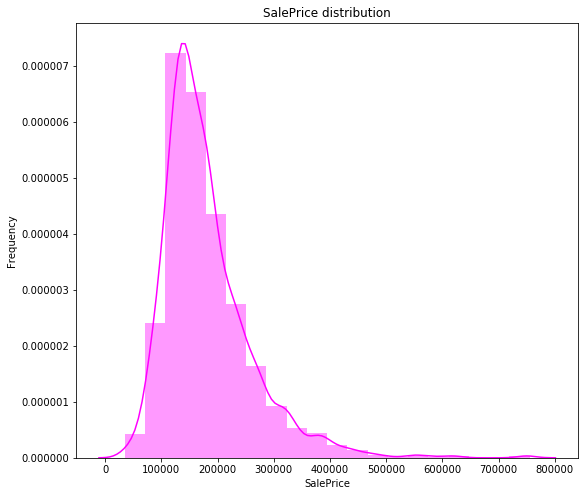

In [13]:
#dependent variable
f, ax = plt.subplots(figsize=(9, 8))
sns.distplot(train_dependent, bins = 20, color = 'Magenta')
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")

Right tailed.

[Text(0.5, 1.0, 'SalePrice distribution')]

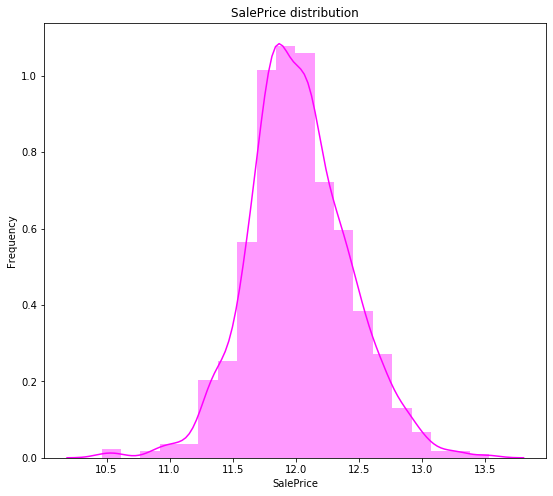

In [14]:
# log transformation
train_dependent = np.log1p(train_dependent)

#after transformation
f, ax = plt.subplots(figsize=(9, 8))
sns.distplot(train_dependent, bins = 20, color = 'Magenta')
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")

In [15]:
# Other numerical variables
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

skew_features = features[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

print("There are {} numerical features with Skew > 0.5 :".format(high_skew.shape[0]))
skewness = pd.DataFrame({'Skew' :high_skew})
skew_features

There are 26 numerical features with Skew > 0.5 :


MiscVal          21.947195
PoolArea         16.898328
LotArea          12.822431
LowQualFinSF     12.088761
3SsnPorch        11.376065
KitchenAbvGr      4.302254
BsmtFinSF2        4.146143
EnclosedPorch     4.003891
ScreenPorch       3.946694
BsmtHalfBath      3.931594
MasVnrArea        2.613592
OpenPorchSF       2.535114
WoodDeckSF        1.842433
1stFlrSF          1.469604
LotFrontage       1.460429
BsmtFinSF1        1.425230
MSSubClass        1.375457
GrLivArea         1.269358
TotalBsmtSF       1.156894
BsmtUnfSF         0.919339
2ndFlrSF          0.861675
TotRmsAbvGrd      0.758367
Fireplaces        0.733495
HalfBath          0.694566
BsmtFullBath      0.624832
OverallCond       0.570312
BedroomAbvGr      0.326324
GarageArea        0.239257
OverallQual       0.197110
MoSold            0.195884
FullBath          0.167606
GarageCars       -0.219581
GarageYrBlt      -3.906205
dtype: float64

In [16]:
# Normalize skewed features with boxcox transformation
for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

## Multicolinearity

In [17]:
#defining numerical features again to include the added features for the correlation plot to be plotted.
numerical_features = []
for column in train_independent.columns:
    if train_independent[column].dtype in ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']:
        numerical_features.append(column)

new_train_set = pd.concat([features.iloc[:len(train_dependent), :], train_dependent], axis=1)

method from https://www.kaggle.com/pcbreviglieri/enhanced-house-price-predictions/notebook#Enhanced-House-Price-Predictions

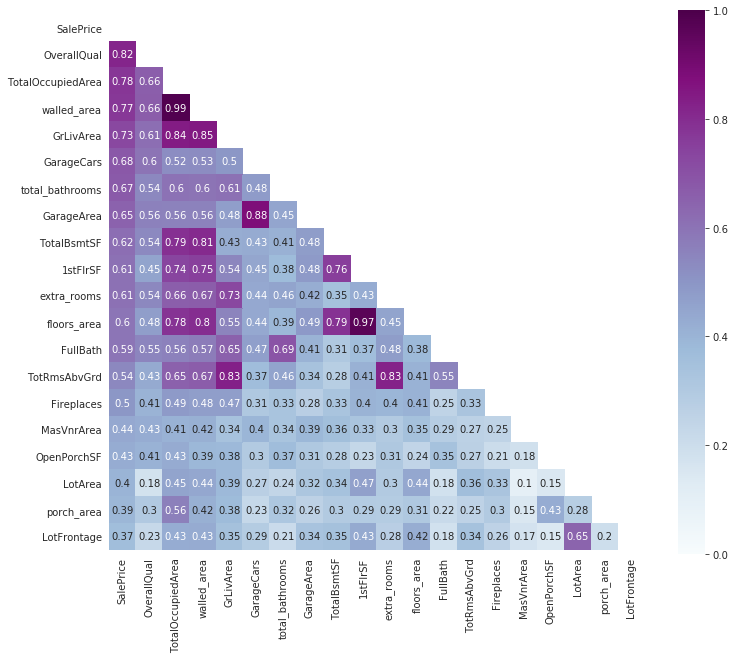

In [18]:
def correlation_map(f_data, f_feature, f_number):
    f_most_correlated = f_data.corr().nlargest(f_number,f_feature)[f_feature].index
    f_correlation = f_data[f_most_correlated].corr()
    
    f_mask = np.zeros_like(f_correlation)
    f_mask[np.triu_indices_from(f_mask)] = True
    with sns.axes_style("white"):
        f_fig, f_ax = plt.subplots(figsize=(12, 10))
        f_ax = sns.heatmap(f_correlation, mask=f_mask, vmin=0, vmax=1, square=True,
                           annot=True, annot_kws={"size": 10}, cmap="BuPu")

    plt.show()

correlation_map(new_train_set, 'SalePrice', 20)

In [19]:
#dropping features with high correlation with other independent variables to avoid chances of multicolinearity.
features = features.drop(['GarageCars','1stFlrSF', 'walled_area'], axis = 1)

## Encoding categorical variables

In [20]:
features = pd.get_dummies(features).reset_index(drop=True)
features.shape

(2919, 489)

The extra number of columns can be seen after encoding.

#### dropping columns with predominant 0 values

method from https://www.kaggle.com/pcbreviglieri/enhanced-house-price-predictions/notebook#Enhanced-House-Price-Predictions again.

In [21]:
features_to_be_dropped = []
for feature in features.columns:
    all_value_counts = features[feature].value_counts()
    zero_value_counts = all_value_counts.iloc[0]
    if zero_value_counts / len(features) > 0.995:
        features_to_be_dropped.append(feature)
print('\nFeatures with predominant zeroes:\n')
print(features_to_be_dropped)

features = features.drop(features_to_be_dropped, axis=1).copy()
features.shape


Features with predominant zeroes:

['PoolArea', 'Street_Grvl', 'Street_Pave', 'Utilities_AllPub', 'Utilities_NoSeWa', 'Utilities_Null', 'LotConfig_FR3', 'Neighborhood_Blueste', 'Condition1_RRNe', 'Condition1_RRNn', 'Condition2_Artery', 'Condition2_Feedr', 'Condition2_PosA', 'Condition2_PosN', 'Condition2_RRAe', 'Condition2_RRAn', 'Condition2_RRNn', 'HouseStyle_2.5Fin', 'YearBuilt_1872', 'YearBuilt_1875', 'YearBuilt_1879', 'YearBuilt_1880', 'YearBuilt_1882', 'YearBuilt_1885', 'YearBuilt_1890', 'YearBuilt_1892', 'YearBuilt_1893', 'YearBuilt_1895', 'YearBuilt_1896', 'YearBuilt_1898', 'YearBuilt_1901', 'YearBuilt_1902', 'YearBuilt_1904', 'YearBuilt_1905', 'YearBuilt_1906', 'YearBuilt_1907', 'YearBuilt_1908', 'YearBuilt_1911', 'YearBuilt_1912', 'YearBuilt_1913', 'YearBuilt_1914', 'YearBuilt_1916', 'YearBuilt_1917', 'YearBuilt_1918', 'YearBuilt_1919', 'YearBuilt_1921', 'YearBuilt_1927', 'YearBuilt_1928', 'YearBuilt_1929', 'YearBuilt_1931', 'YearBuilt_1932', 'YearBuilt_1934', 'YearBuilt_1935

(2919, 366)

## Feature Transformations

In [22]:
# def logs(res, ls):
#     m = res.shape[1]
#     for l in ls:
#         res = res.assign(newcol=pd.Series(np.log(1.01+res[l])).values)   
#         res.columns.values[m] = l + '_log'
#         m += 1
#     return res

# log_features = ['LotFrontage','LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF',
#                  'TotalBsmtSF','2ndFlrSF','LowQualFinSF','GrLivArea',
#                  'BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr',
#                  'TotRmsAbvGrd','Fireplaces','GarageArea','WoodDeckSF','OpenPorchSF',
#                  'EnclosedPorch','3SsnPorch','ScreenPorch','MiscVal']

# features = logs(features, log_features)


### Reconstructing train and test sets

In [23]:
x_train = features.iloc[:len(train_dependent), :]
x_test = features.iloc[len(train_dependent):, :]
y_train = train_dependent
train_set = pd.concat([x_train, y_train], axis=1)

In [24]:
print('train features:', x_train.shape)
print('train target:', y_train.shape)
print('test features:', x_test.shape)
print('train set:', train_set.shape)

train features: (1460, 366)
train target: (1460,)
test features: (1459, 366)
train set: (1460, 367)


## Model Selection, Stacking, Fitting and Preicting.

***gradientboostingregressor, xgbregressor, randomforestregressor, adaboostregressor, ridgecv, stackngcvregressor***

In [25]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error
from mlxtend.regressor import StackingCVRegressor
import xgboost
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV


#randomforest
rf = RandomForestRegressor(n_estimators=300, random_state=0)

#adaboost
ada = AdaBoostRegressor(learning_rate = 0.05, loss =  'linear', n_estimators = 100 , random_state = 0)

#xgb
xgb = XGBRegressor(learning_rate=0.01, n_estimators=6000, max_depth=3, min_child_weight=0, gamma=0, subsample=0.7, colsample_bytree=0.7,
                       objective='reg:squarederror', nthread=-1, scale_pos_weight=1, seed=27, reg_alpha=0.00006, random_state=0)

#ridgecv
kfolds = KFold(n_splits=10, shuffle=True, random_state=0)
ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=[13.5, 14, 14.5, 15, 15.5], cv=kfolds))

#gradient
grad = GradientBoostingRegressor(n_estimators=4000, learning_rate=0.01, max_depth=4, max_features='sqrt', min_samples_leaf=15, 
                                 min_samples_split=10, loss='huber', random_state=0)

#stackcv 
stackcv = StackingCVRegressor(regressors=(rf, ada, xgb, 
                                          ridge, grad),
                              meta_regressor=xgb,
                              use_features_in_secondary=True)

In [26]:
#individual performance
scores_rf = -1 * cross_val_score(rf, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_ada = -1 * cross_val_score(ada, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_xgb = -1 * cross_val_score(xgb, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_ridge = -1 * cross_val_score(ridge, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
scores_grad = -1 * cross_val_score(grad, x_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print('random forest mae:', scores_rf.mean())
print('Ada boost:', scores_ada.mean())
print('xgboost:', scores_xgb.mean())
print('ridgecv:', scores_ridge.mean())
print('Gradient Boosting:', scores_grad.mean())

random forest mae: 0.0941561059220573
Ada boost: 0.12793135964747818
xgboost: 0.07855885831613703
ridgecv: 0.08484636945674344
Gradient Boosting: 0.0780436339121878


Adaboost kinda sucks

In [27]:
#fitting
rf_fit = rf.fit(x_train, y_train)
ada_fit = ada.fit(x_train, y_train)
xgb_fit = xgb.fit(x_train, y_train)
ridge_fit = ridge.fit(x_train, y_train)
grad_fit = grad.fit(x_train, y_train)

stackcv_fit = stackcv.fit(np.array(x_train), np.array(y_train))

In [28]:
blend = [0.1994, 0.0000, 0.2031, 0.2017, 0.2032, 0.2043]

In [29]:
#blending                
y_pred = np.expm1((blend[0] * rf_fit.predict(x_test)) +
                  (blend[1] * ada_fit.predict(x_test)) +
                  (blend[2] * xgb_fit.predict(x_test)) +
                  (blend[3] * ridge_fit.predict(x_test)) +
                  (blend[4] * grad_fit.predict(x_test)) +
                  (blend[5] * stackcv_fit.predict(np.array(x_test))))

## Submission

In [30]:
submission = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv')
submission.iloc[:, 1] = np.round_(y_pred)
submission.to_csv('submission_z.csv', index=False)